In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
    NegativeLowerConfidenceBound, MaxValueEntropySearch

from utils import get_array_and_len, x_scaler, x_descaler, get_closest_array, \
    define_parameter_space, get_rbf_kernel, get_gpr_model, get_matern52_kernel, \
    generate_visualization_efficiency_vs_ml_conditions, generate_contour_plot, \
    generate_visualization_suggested_process_conditions
from utils import ScaledProbabilityOfFeasibility, ProbabilisticConstraintBayesianOptimizationLoop2

In [2]:
# Assuming your data is in an Excel file named 'your_data.xlsx'.
file_path = './器件薄膜数据.xlsx'
sheet_name = '2022_07_15_film'

df_film = pd.read_excel(file_path, sheet_name=sheet_name)
print(df_film.columns)

# Renaming the columns
df_film.columns = ['Condition', 'NMP (mL)', 'DMF (mL)', 'DMSO (mL)', 'Perovskite concentration (M)',  'Annealing temperature (℃)', 'Vacuum Pressure (Pa)', 'Vacuum Pressure time (s)', 'Temperature (℃)', 'Humidity (%)', 'Success or Fail']

# Filter the successful conditions
success_conditions = df_film[df_film['Success or Fail'] == 1]['Condition'].values

# Display the DataFrame
#df_film


Index(['Condition', 'NMP(mL)', 'DMF(mL)', 'DMSO(mL)',
       'Perovskite concentration(M)', 'Annealing temperature(℃)',
       'Vacuum Pressure(Pa)', 'Vacuum Pressure time(s)', 'Temperature(℃)',
       'humidity(%)', 'Success or Fail'],
      dtype='object')


In [3]:
import pandas as pd

# Assuming your data is in an Excel file named 'your_data.xlsx' and the sheet name is '2022-device'.
file_path = './器件薄膜数据.xlsx'
sheet_name = '2022_07_15_device'

df_device = pd.read_excel(file_path, sheet_name=sheet_name)
print(df_device.columns)

df_device.columns = ['Condition', 'NMP (mL)', 'DMF (mL)', 'DMSO (mL)', 'Perovskite concentration (M)', 'Annealing temperature (℃)', 'Vacuum Pressure (Pa)', 'Vacuum Pressure time (s)', 'Temperature (℃)', 'Humidity (%)',
                     'Voc(V)', 'FF(%)', 'Eff(%)', 'Jsc(mA/cm^2)']
# Filter data based on success_conditions
success_conditions = [0, 2, 4, 5, 6, 7, 8, 11, 12, 17, 18]
df_device = df_device.sort_values(by=list(df_device.iloc[:,[0,-1]].columns)).drop_duplicates('Condition', keep = 'last', ignore_index = True)
df_device = df_device[df_device['Condition'].isin(success_conditions)]

# Display the DataFrame
# df_device

Index(['Condition', 'NMP(mL)', 'DMF(mL)', 'DMSO(mL)',
       'Perovskite concentration(M)', 'Annealing temperature(℃)',
       'Vacuum Pressure(Pa)', 'Vacuum Pressure time(s)', 'Temperature(℃)',
       'humidity(%)', 'Voc (V)', 'FF (%)', 'Eff (%)', 'Jsc (mA/cm^2)'],
      dtype='object')


In [4]:
# Load the dataset
df_previous = pd.read_excel("./限制性数据.xlsx")

# Change the column names
df_previous.columns = [
    '',
    'NMP (mL)',
    'DMF (mL)',
    'DMSO (mL)',
    'Perovskite concentration (M)',
    'Annealing temperature (℃)',
    'Vacuum Pressure (Pa)',
    'Vacuum Pressure time (s)',
    'Temperature (℃)',
    'Humidity (%)',
    'Voc(V)',
    'FF(%)',
    'Eff(%)',
    'Jsc(mA/cm^2)'
]

# Remove the first column
df_previous = df_previous.iloc[:, 1:]

#df_previous

In [5]:
import numpy as np

## Total process conditions: NMP x DMF x DMSO x PC x AT x VP x VT x T = 1871100000 conditions

NMP_min, NMP_max, NMP_step = [0, 50, 5] ## Unit: ml ## 10 steps
NMP_var, NMP_num = get_array_and_len(NMP_min, NMP_max, NMP_step)

DMF_min, DMF_max, DMF_step = [0, 100, 5] ## Unit: ml ## 50 steps
DMF_var, DMF_num = get_array_and_len(DMF_min, DMF_max, DMF_step)

DMSO_min, DMSO_max, DMSO_step = [0, 50, 5] ## Unit: ml ## 10 steps
DMSO_var, DMSO_num = get_array_and_len(DMSO_min, DMSO_max, DMSO_step)

PC_min, PC_max, PC_step = [0.8, 1.8, 0.1] ## Unit: M ## 10 steps
PC_var, PC_num = get_array_and_len(PC_min, PC_max, PC_step)

AT_min, AT_max, AT_step = [100, 170, 10] ## Unit: °C ## 7 steps
AT_var, AT_num = get_array_and_len(AT_min, AT_max, AT_step)

VP_min, VP_max, VP_step = [20, 350, 10] ## Unit: Pa ## 33 steps
VP_var, VP_num = get_array_and_len(VP_min, VP_max, VP_step)

VT_min, VT_max, VT_step = [5, 50, 5] ## Unit: s ## 9 steps
VT_var, VT_num = get_array_and_len(VT_min, VT_max, VT_step)

T_min, T_max, T_step = [15, 30, 5] ## Unit: °C ## 3 steps
T_var, T_num = get_array_and_len(T_min, T_max, T_step)

humidity_min, humidity_max, humidity_step = [15, 45, 5]  # Unit: [%] ## 6 steps
humidity_var, humidity_num = get_array_and_len(humidity_min, humidity_max, humidity_step)

var_array = [NMP_var, DMF_var,
DMSO_var, PC_var,
AT_var, VP_var,
VT_var, T_var, humidity_var]

x_labels = ['NMP [ml]',
'Dimethylformamide [ml]',
'Dimethyl Sulfoxide [ml]',
'Perovskite Concentration [M]',
'Annealing Temperature [\N{DEGREE SIGN}C]',
'Vacuum Pressure [Pa]',
'Vacuum Time [s]',
'Temperature [\N{DEGREE SIGN}C]',
'Humidity [%]']

In [6]:
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

parameter_space = define_parameter_space(NMP_num, DMF_num, DMSO_num, PC_num, AT_num, \
                                         VP_num, VT_num, T_num, humidity_num)

In [7]:
np.random.seed(10)

# Preprocess your data
x_init = x_scaler(df_device.iloc[:, 1:10].values, var_array)
y_init = np.transpose([df_device.iloc[:, -2].values])
xc_init = x_scaler(df_film.iloc[:, 1:-1].values, var_array)
yc_init = np.transpose([df_film.iloc[:, -1].values])
X, Y, Xc, Yc = [x_init, y_init, xc_init, yc_init]

Xc2 = x_scaler(df_previous.iloc[:,0:9].values, var_array)
Yc2 = np.transpose([df_previous.iloc[:,-2].values])

# get objective model
input_dim = len(X[0])
ker = get_matern52_kernel(input_dim)
model_gpy = get_gpr_model(X, Y, ker, set_noise=True)
objective_model = GPyModelWrapper(model_gpy)

# get constraint model 1
input_dim_c = len(Xc[0])
ker_c = get_rbf_kernel(input_dim_c)
yc_offset = 0.5 # constraint acquisition computes the probability of <0
gpy_constraint_model = get_gpr_model(Xc, Yc-yc_offset, ker_c) 
constraint_model1 = GPyModelWrapper(gpy_constraint_model)

# get_constraint_model 2
input_dim_c2 = len(Xc2[0])
ker_c2 = get_rbf_kernel(input_dim_c2)
yc2_offset = np.mean(Yc2)  # constraint acquisition computes the probability of <0
gpy_constraint_model2 = get_gpr_model(Xc2, Yc2-yc2_offset, ker_c2) 
constraint_model2 = GPyModelWrapper(gpy_constraint_model2)

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.variance
reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.variance


In [8]:
objective_model.model.kern.lengthscale

index,GP_regression.Mat52.lengthscale,constraints,priors
[0],0.99999999,"0.1,1.0",
[1],0.99999994,"0.1,1.0",
[2],1.00000000,"0.1,1.0",
[3],1.00000000,"0.1,1.0",
[4],1.00000000,"0.1,1.0",
[5],0.64446488,"0.1,1.0",
[6],0.99999998,"0.1,1.0",
[7],0.75916488,"0.1,1.0",
[8],0.48422859,"0.1,1.0",


# Start the First Run of the Batch-mode Bayesian Optimization

In [9]:
import numpy as np
## Expeceted Improvement (EI)
#acquisition = ExpectedImprovement(objective_model, jitter=.1)
## Lower Confidence Bound (LCB)
acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)

# Make loop and collect points
bayesopt_cons_pr = ProbabilisticConstraintBayesianOptimizationLoop2(model_objective=objective_model, 
                                                          space=parameter_space, 
                                                          acquisition=acquisition,
                                                          model_constraint1=constraint_model1,
                                                          model_constraint2=constraint_model2,
                                                          batch_size = 22)

X_new = bayesopt_cons_pr.candidate_point_calculator.compute_next_points(bayesopt_cons_pr.loop_state)
X_new = x_scaler(get_closest_array(x_descaler(X_new, var_array), var_array), var_array)

f_obj =  objective_model.model.predict       
f_cons1 = constraint_model1.model.predict
f_cons2 = constraint_model2.model.predict

f_cons_acq = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.evaluate
f_raw_acq = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.acquisition_1.evaluate
f_cons_pr = bayesopt_cons_pr.candidate_point_calculator.acquisition.acquisition.acquisition_2.evaluate

print('total condition no.:', len(Xc))
print('total device no.:', len(bayesopt_cons_pr.loop_state.Y))
print('maximum Y (PCE [%]): ', -np.min(np.transpose(np.round(bayesopt_cons_pr.loop_state.Y, 2))))

df_Xnew = pd.DataFrame(get_closest_array(x_descaler(X_new, var_array), var_array), columns = df_film.columns[1:10])
df_all = pd.concat([df_film.iloc[:,1:10], df_Xnew])
df_all_ = df_all.drop_duplicates()
df_Xnew = df_all_.iloc[15:40]
df_Xnew = df_Xnew.sort_values(by=list(df_film.columns[1:-1]), ignore_index = True)
df_Xnew.index = np.arange(len(df_Xnew))+len(df_film)

df_Xnew

[ -2.5         86.371579    11.22195181   1.44516432 126.99718587
  75.02569553  19.27648851  24.53853954  30.17120317]
[ -2.5         85.86253479  11.95430237   1.45982661 127.31359374
  75.29042882  21.06942596  24.61712922  29.74833134]
[ -0.77781568  87.24870264  12.48073575   1.48077157 122.840729
  57.39448219  19.80891615  24.64342326  29.56643853]
[ -2.5         23.64890269  52.5          1.24619048 125.46610156
  15.           2.5         25.05740592  30.10980693]
[ -0.20714001  86.17169644  11.43695289   1.44452827 122.30985253
  55.16834667  20.88294662  24.71565042  29.27909174]
[ -2.5         86.52489794  11.34307293   1.4478903  128.16433312
  73.96794924  19.11669476  24.51825663  30.03488087]
[  1.07855751  87.08672047  11.34964205   1.46821839 128.67335676
  59.16085978  18.68455231  24.4882256   30.09693812]
[ -2.5         86.39861136  11.35641825   1.44710852 126.85346123
  77.90313049  19.05858396  24.53543742  30.09526137]
[ 44.58975381  56.17205058   6.60448175   

,NMP (mL),DMF (mL),DMSO (mL),Perovskite concentration (M),Annealing temperature (℃),Vacuum Pressure (Pa),Vacuum Pressure time (s),Temperature (℃),Humidity (%)
20,0.0,25.0,50.0,1.20,130.0,20.0,5.0,25.0,30.0
21,0.0,25.0,50.0,1.20,130.0,20.0,20.0,25.0,30.0
22,0.0,45.0,55.0,1.10,120.0,400.0,40.0,25.0,30.0
23,0.0,55.0,45.0,1.00,145.0,180.0,50.0,25.0,30.0
24,0.0,85.0,10.0,1.40,120.0,60.0,20.0,25.0,30.0
25,0.0,85.0,10.0,1.40,130.0,60.0,20.0,25.0,30.0
26,0.0,85.0,10.0,1.40,130.0,70.0,20.0,25.0,30.0
27,0.0,85.0,10.0,1.40,130.0,80.0,20.0,25.0,30.0
28,0.0,85.0,10.0,1.50,120.0,60.0,20.0,25.0,30.0
29,0.0,85.0,10.0,1.50,130.0,50.0,20.0,25.0,30.0


In [10]:
X_new = x_scaler(df_Xnew.values, var_array)

y_pred_new, y_uncer_new = f_obj(X_new)
y_pred_new = -y_pred_new
y_uncer_new = np.sqrt(y_uncer_new)

acq_produc = f_cons_acq(X_new)
acq_fcn = f_raw_acq(X_new)
acq_cons = f_cons_pr(X_new)

# Quick histogram visualization of the newly suggested process conditions

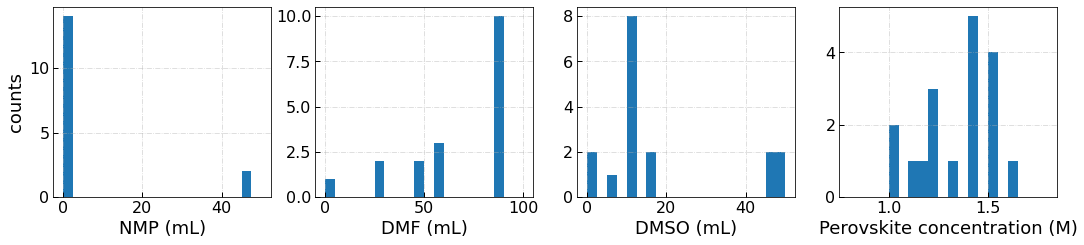

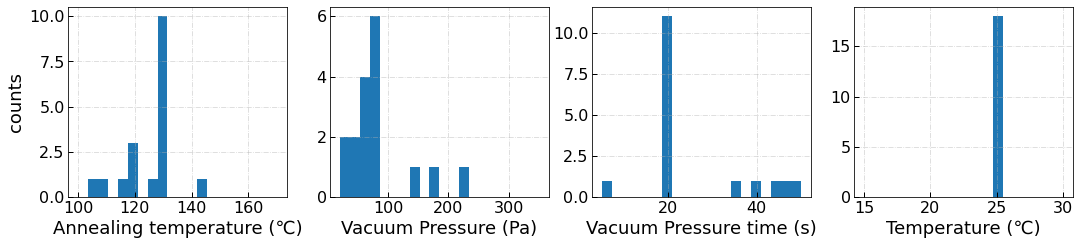

In [11]:
generate_visualization_suggested_process_conditions(df_Xnew, 4, var_array)

# Visualisation of Efficiency vs ML conditions, and Acquisition¶

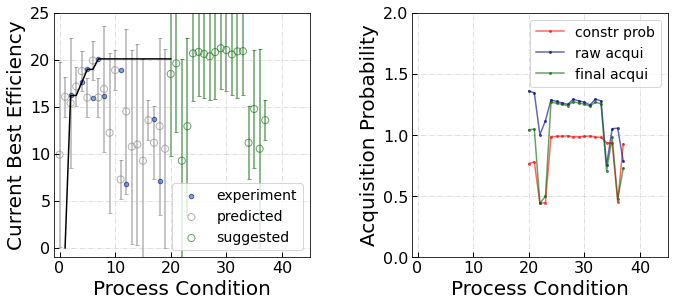

In [12]:
from emukit.core.initial_designs import RandomDesign

f_obj =  objective_model.model.predict       

generate_visualization_efficiency_vs_ml_conditions(X_new, Xc, df_device, df_film, f_obj, \
                                                   acq_fcn, acq_cons, acq_produc, var_array)

In [13]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(1000)
x_columns = df_device.iloc[:,1 :10].columns


def generate_contour_plot(ind1, ind2, x_sampled, f_obj, x_descaler, x_columns):
    n_steps = 21
    x1x2y_pred, x1x2y_uncer = [[], []]
    for x1 in np.linspace(0, 1, n_steps):
        for x2 in np.linspace(0, 1, n_steps):
            x_temp = np.copy(x_sampled)
            x_temp[:, ind1] = x1
            x_temp[:, ind2] = x2
            y_pred, y_uncer = f_obj(x_temp)
            y_pred = -y_pred
            x1_org = x_descaler(x_temp)[0, ind1]
            x2_org = x_descaler(x_temp)[0, ind2]
            x1x2y_pred.append([x1_org, x2_org, np.max(y_pred), np.mean(y_pred), np.min(y_pred)])
            x1x2y_uncer.append([x1_org, x2_org, np.max(np.sqrt(y_uncer)), np.mean(np.sqrt(y_uncer)), np.min(np.sqrt(y_uncer))])

    x1 = np.array(x1x2y_pred, dtype=object)[:, 0].reshape(n_steps, n_steps)
    x2 = np.array(x1x2y_pred, dtype=object)[:, 1].reshape(n_steps, n_steps)

    y_pred_max = np.array(x1x2y_pred, dtype=object)[:, 2].reshape(n_steps, n_steps)
    y_pred_mean = np.array(x1x2y_pred, dtype=object)[:, 3].reshape(n_steps, n_steps)
    y_pred_min = np.array(x1x2y_pred, dtype=object)[:, 4].reshape(n_steps, n_steps)

    y_uncer_max = np.array(x1x2y_uncer, dtype=object)[:, 2].reshape(n_steps, n_steps)
    y_uncer_mean = np.array(x1x2y_uncer, dtype=object)[:, 3].reshape(n_steps, n_steps)
    y_uncer_min = np.array(x1x2y_uncer, dtype=object)[:, 4].reshape(n_steps, n_steps)

    fs = 20
    title_pad = 16

    # Contour for Prediction Efficiency Mean
    fig, axes = plt.subplots(1, 3, figsize=(17, 4), sharey=False, sharex=False)
    fig.subplots_adjust(wspace=0.4, hspace=None)
    colorbar_offset = [12.5, 7, 4]
    for ax, c_offset, y in zip(axes, colorbar_offset,
                               [y_pred_max, y_pred_mean, y_pred_min]):

        c_plt1 = ax.contourf(x1, x2, y, levels=np.arange(19) * 0.25 + c_offset, cmap='plasma', extend = 'both')
        cbar = fig.colorbar(c_plt1, ax=ax)
        cbar.ax.tick_params(labelsize=fs * 0.8)
        ax.set_xlabel(str(x_columns[ind1]), fontsize=fs)
        ax.set_ylabel(str(x_columns[ind2]), fontsize=fs)

        x1_delta = (np.max(x1) - np.min(x1)) * 0.05
        x2_delta = (np.max(x2) - np.min(x2)) * 0.05
        ax.set_xlim(np.min(x1) - x1_delta, np.max(x1) + x1_delta)
        ax.set_ylim(np.min(x2) - x2_delta, np.max(x2) + x2_delta)
        ax.tick_params(direction='in', length=5, width=1, labelsize=fs * 0.8)

    axes[0].set_title('objective fcn max', pad=title_pad, fontsize=fs)
    axes[1].set_title('objective fcn mean', pad=title_pad, fontsize=fs)
    axes[2].set_title('objective fcn min', pad=title_pad, fontsize=fs)

 /Users/thijsstuyver/Desktop/Perovskite/utils.py:234: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


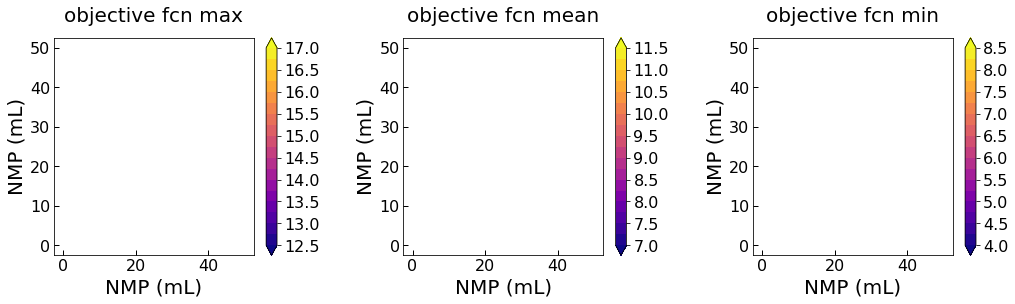

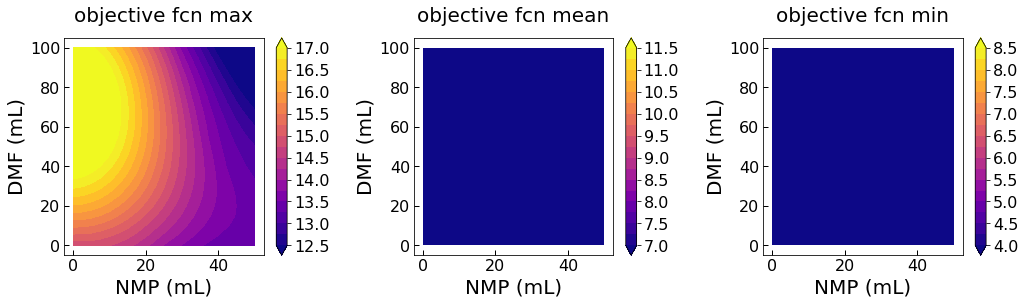

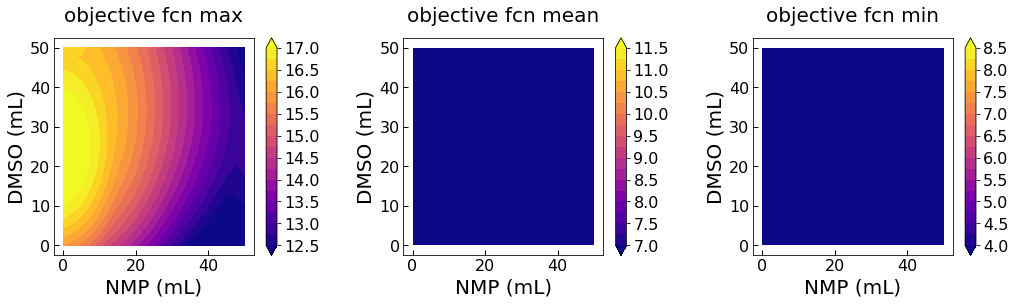

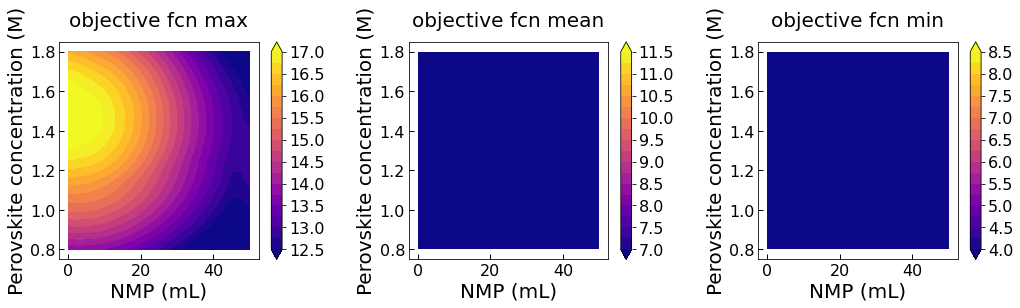

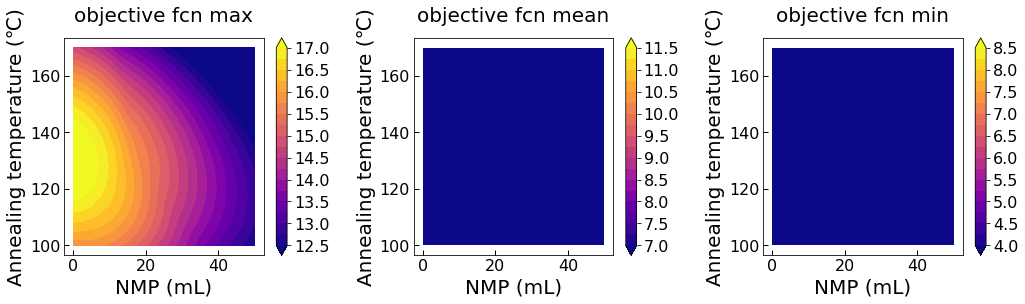

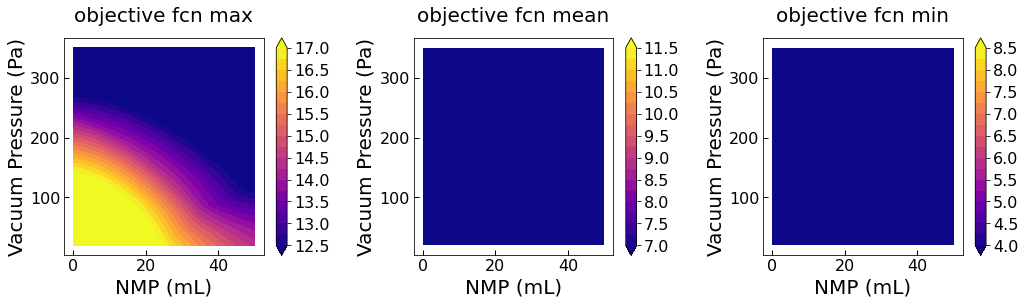

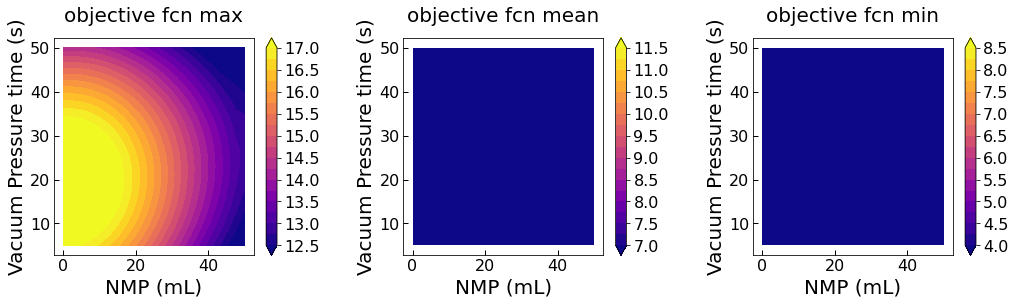

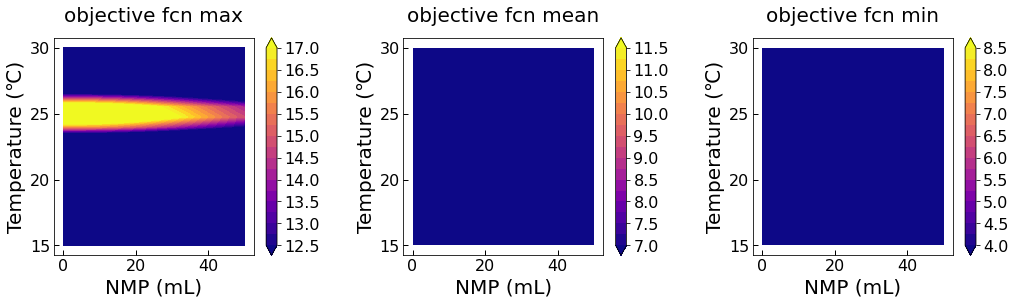

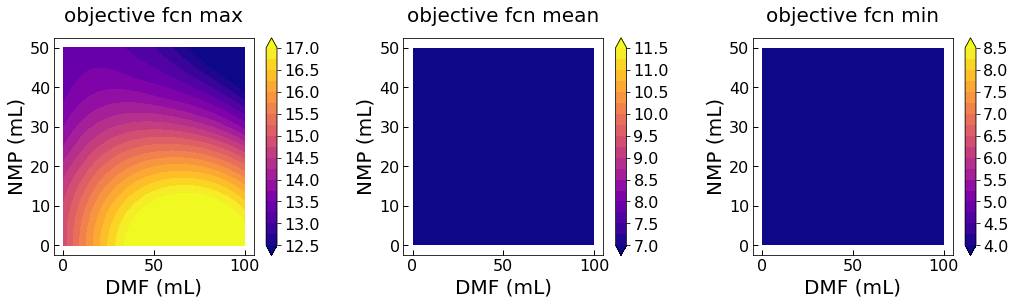

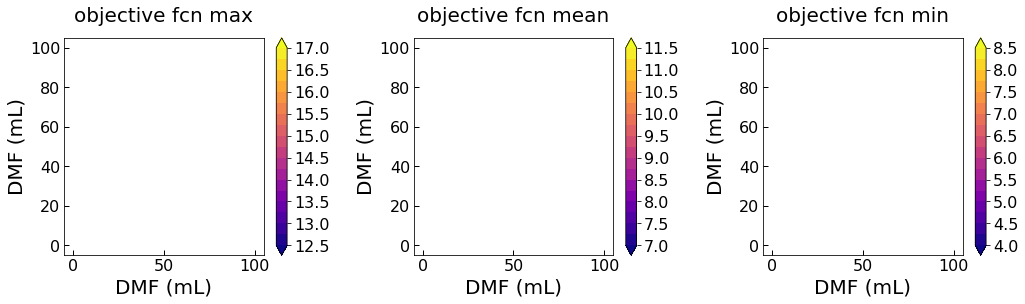

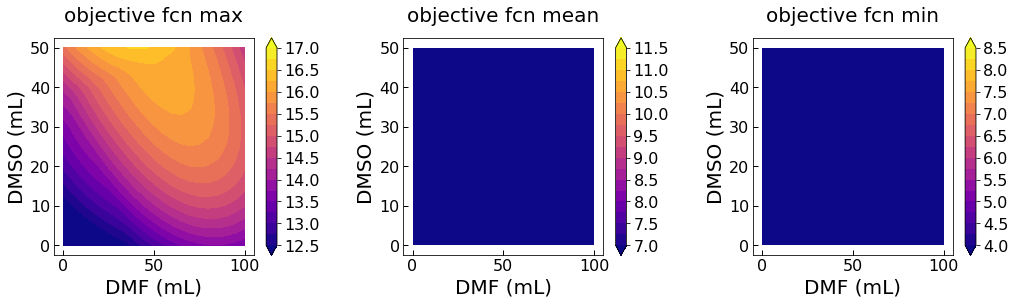

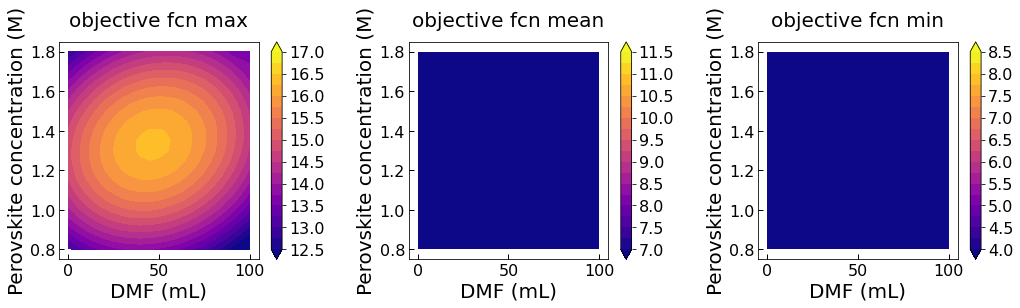

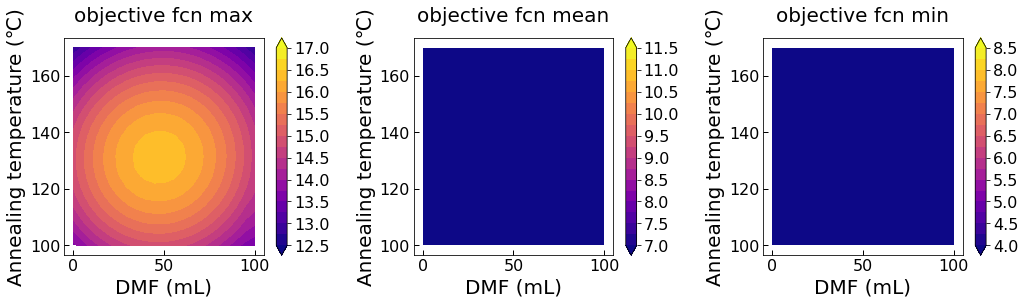

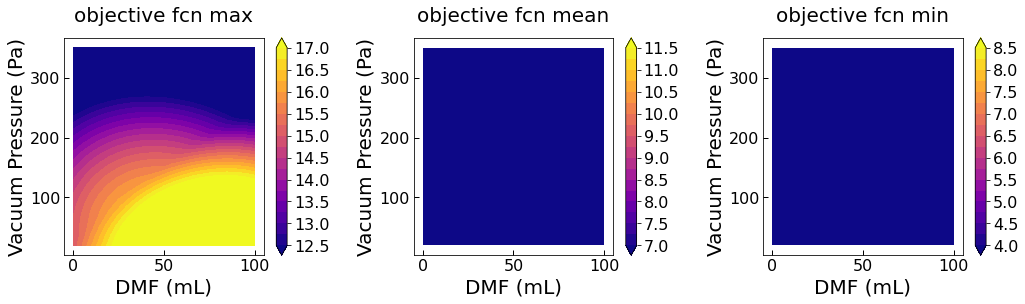

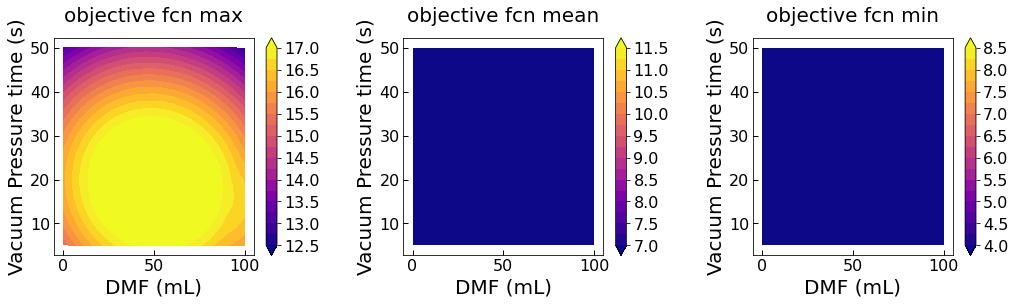

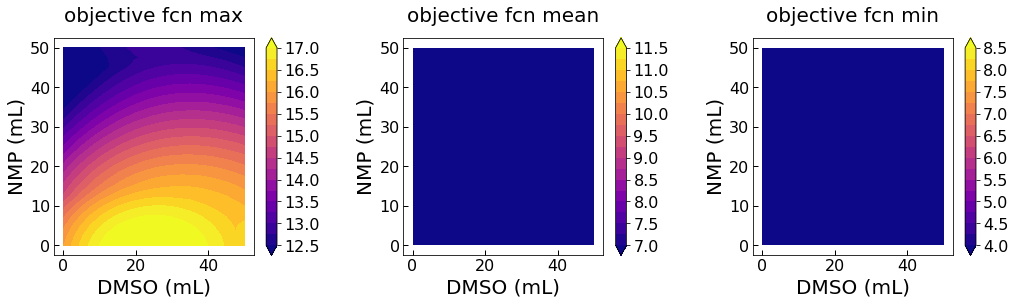

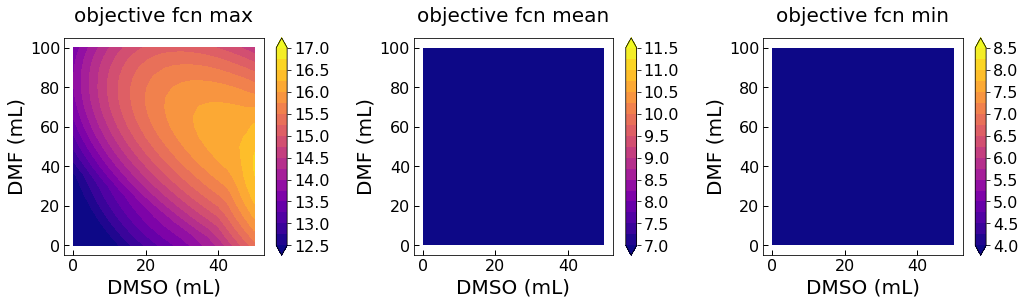

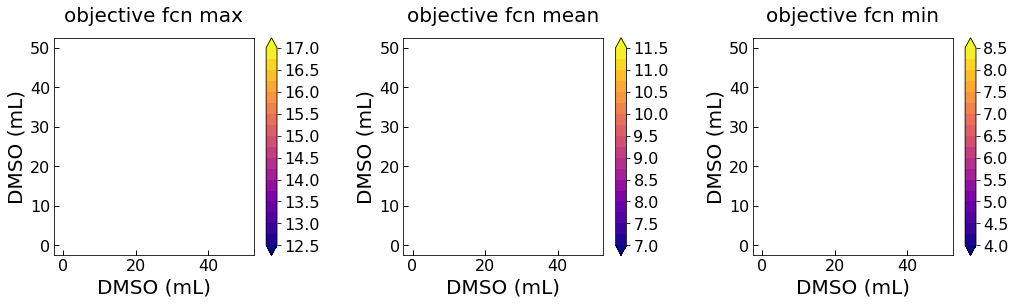

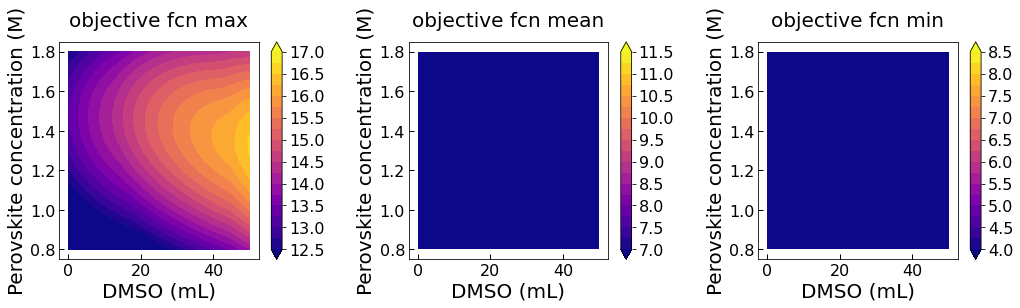

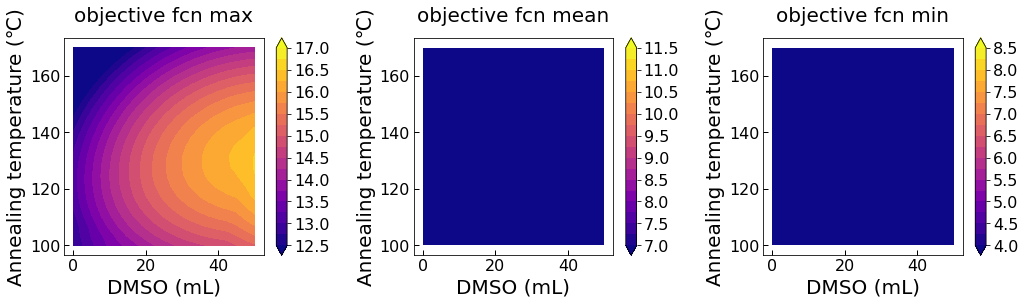

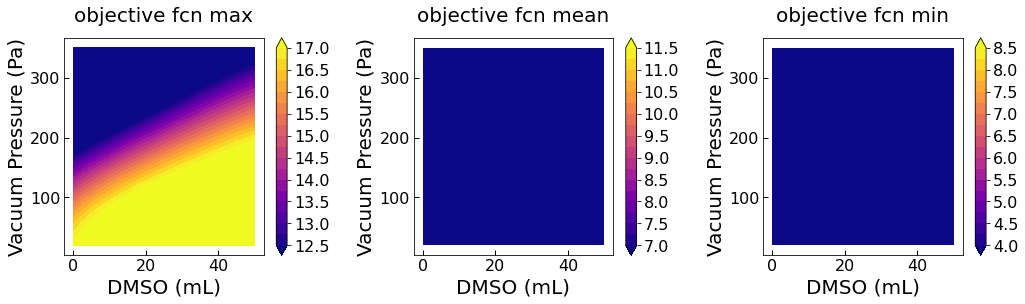

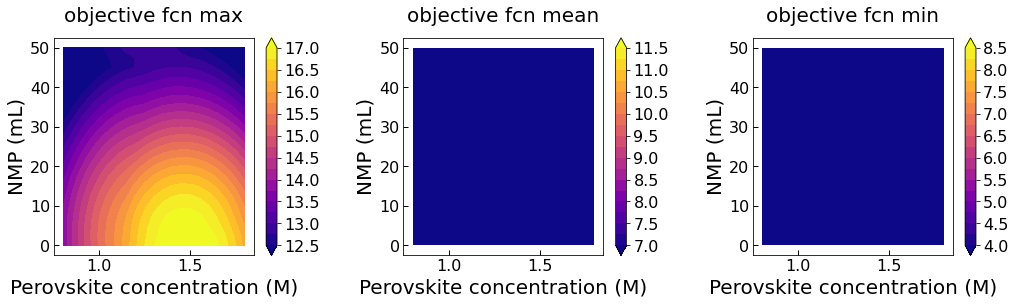

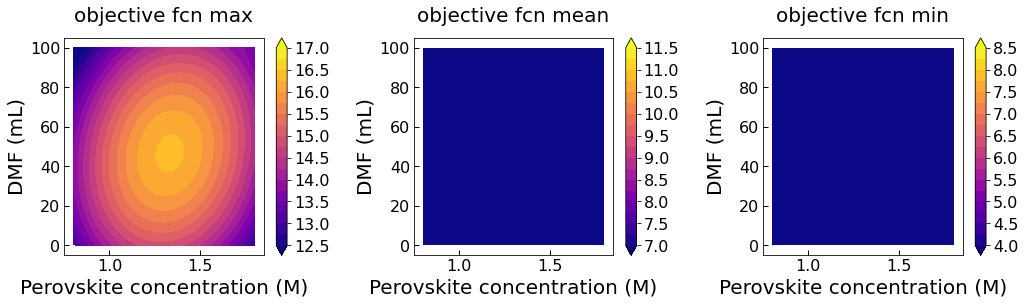

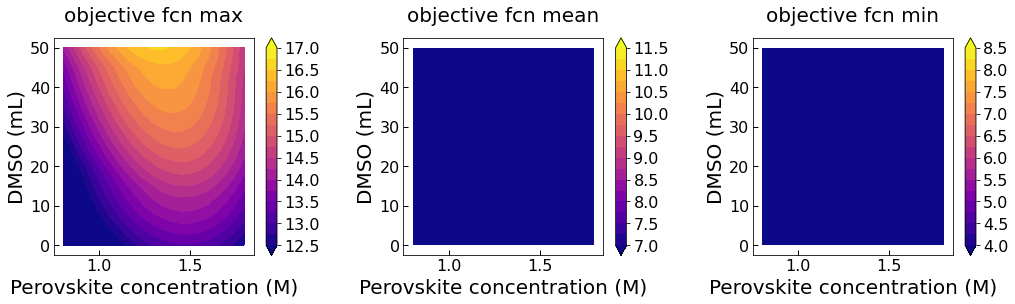

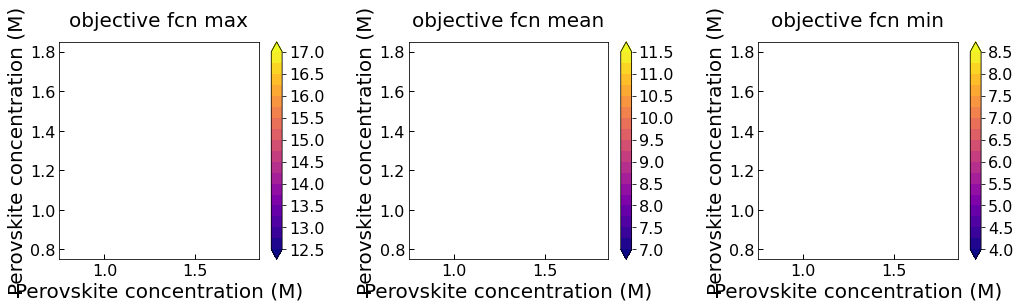

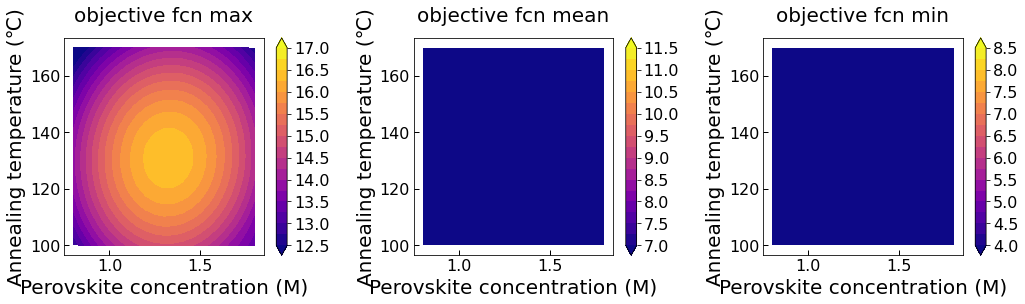

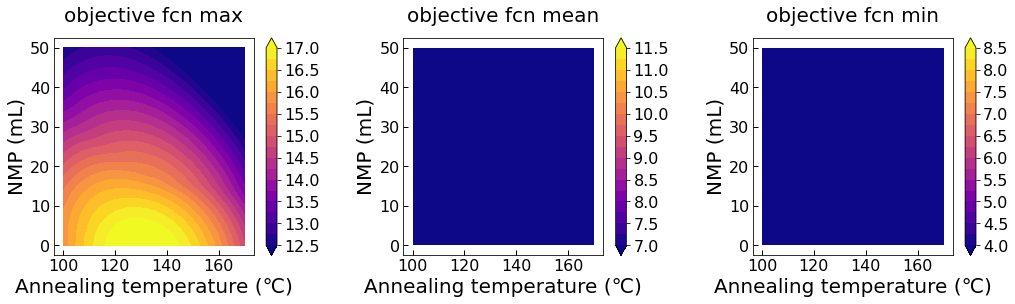

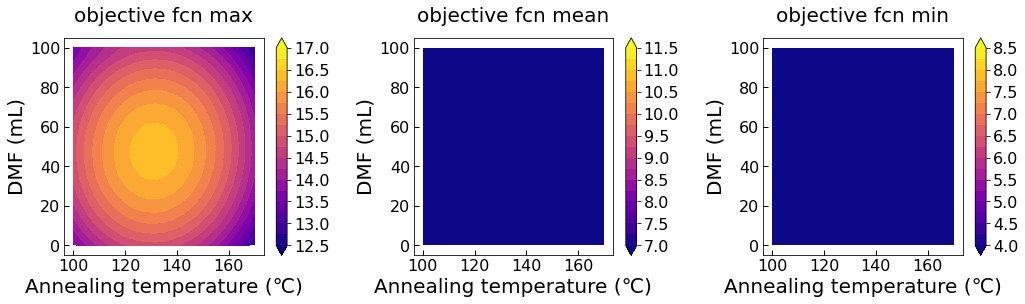

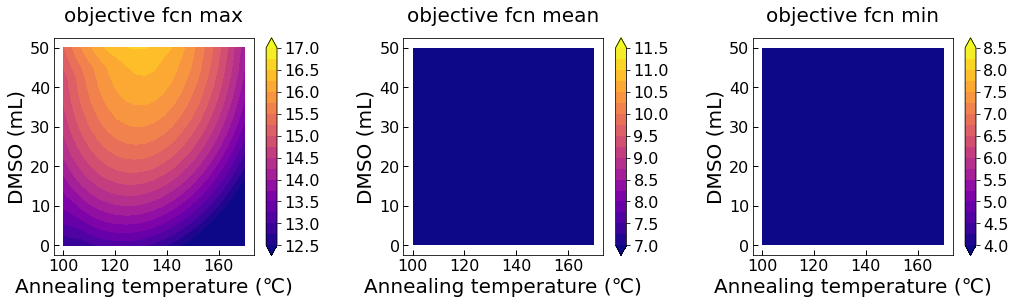

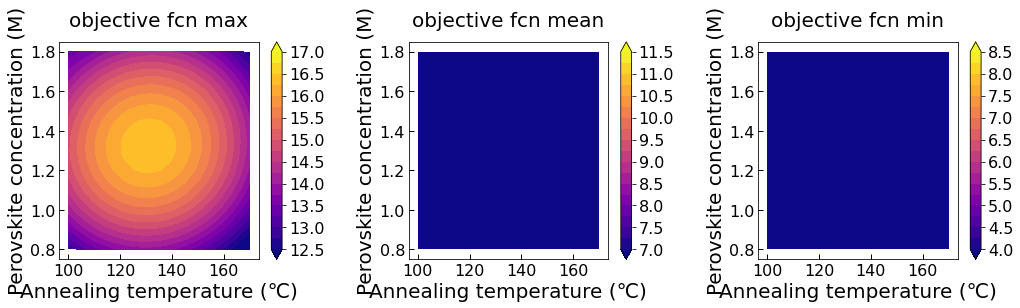

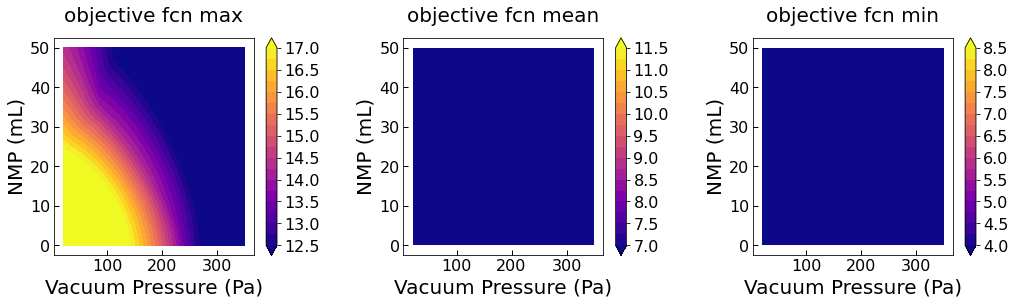

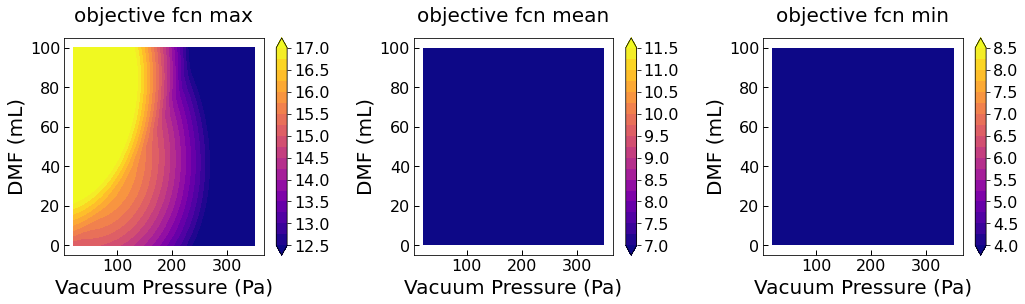

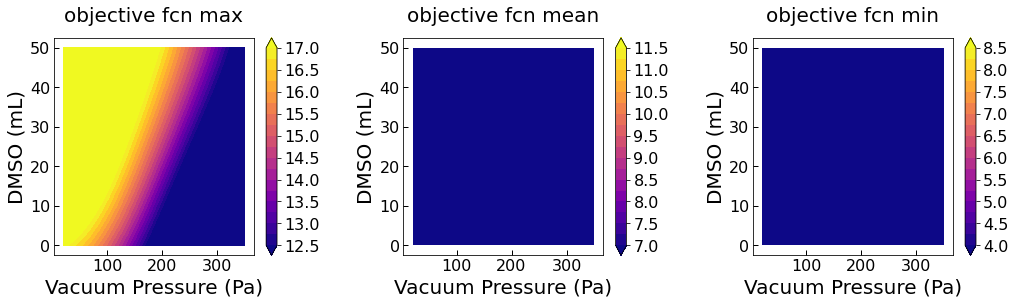

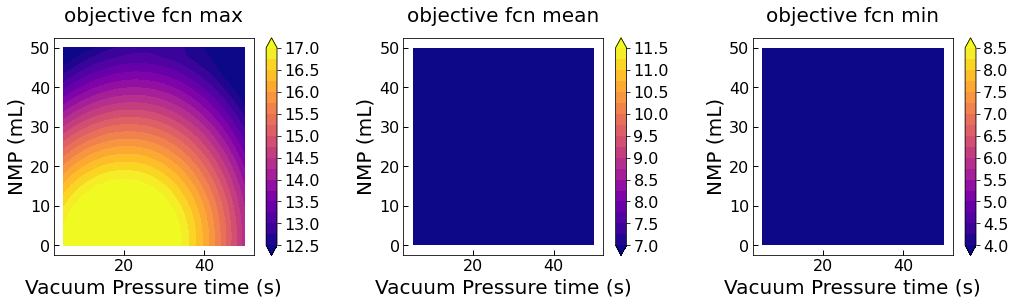

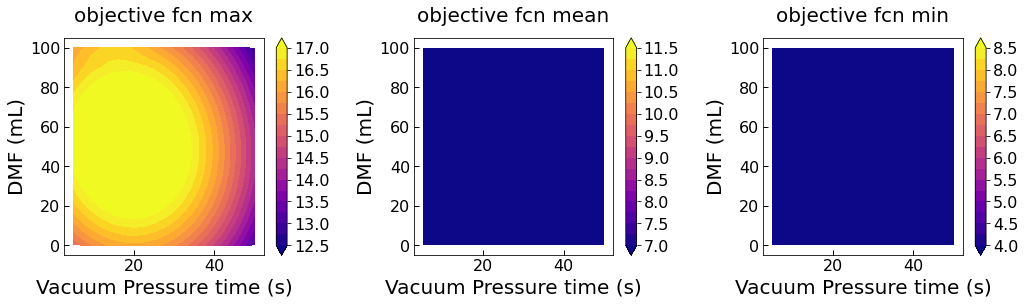

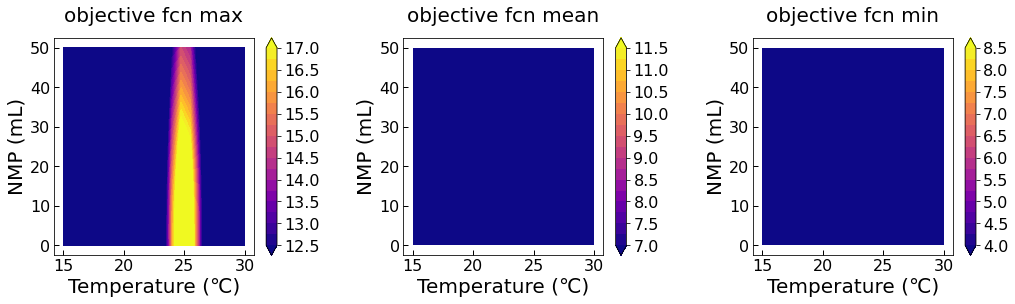

In [19]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(1000)
x_columns = df_device.iloc[:,1 :10].columns

for i in range(input_dim):
    for j in range(input_dim-i-1):
        generate_contour_plot(i, j, x_sampled, f_obj, x_descaler, x_columns, var_array)

In [15]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(1000)
x_columns = df_device.iloc[:,1 :10].columns

for i in range(input_dim):
    for j in range(input_dim-i-1):

        # Generate a 2D grid for Contour plot
        ind1 = i
        ind2 = j+i+1
        n_steps = 21
        x1x2y_pred, x1x2y_uncer = [[], []]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:, ind1] = x1
                x_temp[:, ind2] = x2
                y_pred, y_uncer = f_obj(x_temp)
                y_pred = -y_pred
                x1_org = x_denormalizer(x_temp)[0, ind1]
                x2_org = x_denormalizer(x_temp)[0, ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(y_pred), np.mean(y_pred), np.min(y_pred)])
                x1x2y_uncer.append([x1_org, x2_org, np.max(np.sqrt(y_uncer)), np.mean(np.sqrt(y_uncer)), np.min(np.sqrt(y_uncer))])

        x1 = np.array(x1x2y_pred, dtype=object)[:, 0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=object)[:, 1].reshape(n_steps, n_steps)

        y_pred_max = np.array(x1x2y_pred, dtype=object)[:, 2].reshape(n_steps, n_steps)
        y_pred_mean = np.array(x1x2y_pred, dtype=object)[:, 3].reshape(n_steps, n_steps)
        y_pred_min = np.array(x1x2y_pred, dtype=object)[:, 4].reshape(n_steps, n_steps)

        y_uncer_max = np.array(x1x2y_uncer, dtype=object)[:, 2].reshape(n_steps, n_steps)
        y_uncer_mean = np.array(x1x2y_uncer, dtype=object)[:, 3].reshape(n_steps, n_steps)
        y_uncer_min = np.array(x1x2y_uncer, dtype=object)[:, 4].reshape(n_steps, n_steps)

        fs = 20
        title_pad = 16

        # Contour for Prediction Efficiency Mean
        fig, axes = plt.subplots(1, 3, figsize=(17, 4), sharey=False, sharex=False)
        fig.subplots_adjust(wspace=0.4, hspace=None)
        colorbar_offset = [12.5, 7, 4]
        for ax, c_offset, y in zip(axes, colorbar_offset,
                                   [y_pred_max, y_pred_mean, y_pred_min]):

            c_plt1 = ax.contourf(x1, x2, y, levels=np.arange(19) * 0.25 + c_offset, cmap='plasma', extend = 'both')
            #c_plt1 = ax.contourf(x1, x2, y, levels=np.linspace(17, 17, 20).tolist(), cmap='plasma', extend = 'both')
            #c_plt1 = ax.contourf(x1, x2, y, levels=np.linspace(np.min(y), np.max(y), 20), cmap='plasma', extend = 'both')
            cbar = fig.colorbar(c_plt1, ax=ax)
            cbar.ax.tick_params(labelsize=fs * 0.8)
            #ax.scatter(x_denormalizer(X)[:, ind1],
                       #x_denormalizer(X)[:, ind2],
                       #s=30, facecolors='gray', alpha=0.5, edgecolor='gray')
            #ax.scatter(x_denormalizer(X_new)[:, ind1],
                       #x_denormalizer(X_new)[:, ind2],
                       #s=50, facecolors='none', alpha=0.9, edgecolor='green')
            ax.set_xlabel(str(x_columns[ind1]), fontsize=fs)
            ax.set_ylabel(str(x_columns[ind2]), fontsize=fs)

            x1_delta = (np.max(x1) - np.min(x1)) * 0.05
            x2_delta = (np.max(x2) - np.min(x2)) * 0.05
            ax.set_xlim(np.min(x1) - x1_delta, np.max(x1) + x1_delta)
            ax.set_ylim(np.min(x2) - x2_delta, np.max(x2) + x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize=fs * 0.8)

           # Update tick marks based on new dataset
            #if ind1 == 4:  # Annealing temperature
                #ax.set_xticks([100, 125, 135, 145, 155])
            #if ind1 == 5:  # Vacuum Pressure
                #ax.set_xticks([50, 100, 200, 250, 270])
            #if ind1 == 6:  # Vacuum Pressure time
                #ax.set_xticks([15, 17, 18, 25, 35, 45, 47])
            #if ind1 == 7:  # Temperature
                #ax.set_xticks([25])
            #if ind1 == 8:  # Humidity
                #ax.set_xticks([30])

            #if ind2 == 4:  # Annealing temperature
                #ax.set_yticks([100, 125, 135, 145, 155])
            #if ind2 == 5:  # Vacuum Pressure
                #ax.set_yticks([50, 100, 200, 250, 270])
            #if ind2 == 6:  # Vacuum Pressure time
                #ax.set_yticks([15, 17, 18, 25, 35, 45, 47])
            #if ind2 == 7:  # Temperature
                #ax.set_yticks([25])
            #if ind2 == 8:  # Humidity
                #ax.set_yticks([30])

        axes[0].set_title('objective fcn max', pad=title_pad, fontsize=fs)
        axes[1].set_title('objective fcn mean', pad=title_pad, fontsize=fs)
        axes[2].set_title('objective fcn min', pad=title_pad, fontsize=fs)

    plt.subplots_adjust(wspace=10)
    plt.show()

NameError: name 'x_denormalizer' is not defined